In [71]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong20.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

age = []
sex = []
race = []
sz = []
fc = []
ts = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))
tsfile = pickle.load(open(f'{demodir}/bsnip_rc_ts_centered.pkl', 'rb'))

for sub in demo['Age_cal']:
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
#     if demo['Race'][sub] not in ['AA', 'CA']:
#         continue
#     if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:
#         continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    subts = sub.replace('.', '_')
    ts.append(tsfile[subts][:,:100])
    
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)
ts = np.stack(ts)

print([a.shape for a in [sex, race, sz, age, fc, ts]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(1244,), (1244,), (1244,), (1244,), (1244, 34716), (1244, 264, 100)]
0.5763665594855305
0.6889067524115756
0.840032154340836
38.209807073954984


In [68]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

def tonp(x):
    return x.detach().cpu().numpy()

def totorch(x):
    return torch.from_numpy(x).float().cuda()

def totorchidcs(x):
    return torch.from_numpy(x).long().cuda() #F.one_hot(torch.from_numpy(x)).float().cuda()

def rmse(yt, yhat):
    return torch.mean((yt-yhat)**2)**0.5

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(34716,100).float().cuda()
        self.l2 = nn.Linear(100,2).float().cuda()
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
def fit(xtr, ytr):
    xtr = totorch(xtr)
    ytr = totorchidcs(ytr)
    
    ce = nn.CrossEntropyLoss()
    mlp = MLP()
    optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-3)

    nepochs = 1000
    pperiod = 100

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = mlp(xtr)
        loss = ce(yhat, ytr)
        loss.backward()
        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(loss)}')

    print('Complete')
    
    return mlp
    
def predict(model, xt):
    xt = totorch(xt)
    with torch.no_grad():
        yhat = model(xt)
        return tonp(yhat)
    
accs = []
    
for i in range(5):
    xtr, xt, ytr, yt = train_test_split(fc, race, stratify=race, train_size=0.8)

#     model = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr)
#     p = model.predict_proba(xt)
    model = fit(xtr, ytr)
    p = predict(model, xt)
    acc = roc_auc_score(yt, p[:,1])
    accs.append(acc)
    print(acc)
    
print('---')    
print(np.mean(accs), np.std(accs))

0 0.7098645567893982
100 0.0682644173502922
200 0.014345664530992508
300 0.007471950259059668
400 0.006395621690899134
500 0.005285091698169708
600 0.00594348507001996
700 0.0051942006684839725
800 0.005070113111287355
900 0.07646926492452621
999 0.00309339864179492
Complete
0.9116716616716617
0 0.6752661466598511
100 0.02770165354013443


KeyboardInterrupt: 

In [72]:

class BrainNetCNN(nn.Module):
    def __init__(self):
        super(BrainNetCNN, self).__init__()
        self.cnn1 = nn.Conv1d(264,10,5).float().cuda()
        self.cnn2 = nn.Conv1d(10,10,5).float().cuda()
        self.pool = nn.AvgPool1d(200,ceil_mode=True).float().cuda()
        self.l1 = nn.Linear(10,2).float().cuda()
        
    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = F.relu(self.cnn2(x))
        x = self.pool(x).squeeze()
        x = self.l1(x)
        return x
      
def fit(xtr, ytr):
    xtr = totorch(xtr)
    ytr = totorchidcs(ytr)
    
    ce = nn.CrossEntropyLoss()
    bnc = BrainNetCNN()
    optim = torch.optim.Adam(bnc.parameters(), lr=1e-3, weight_decay=1e-3)

    nepochs = 1000
    pperiod = 100

    for epoch in range(nepochs):
        optim.zero_grad()
        yhat = bnc(xtr)
        loss = ce(yhat, ytr)
        loss.backward()
        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(loss)}')

    print('Complete')
    
    return bnc
    
def predict(model, xt):
    xt = totorch(xt)
    with torch.no_grad():
        yhat = model(xt)
        return tonp(yhat)
    
accs = []
    
for i in range(5):
    xtr, xt, ytr, yt = train_test_split(ts, race, stratify=race, train_size=0.8)

    model = fit(xtr, ytr)
    p = predict(model, xt)
    acc = roc_auc_score(yt, p[:,1])
    accs.append(acc)
    print(acc)
    
print('---')    
print(np.mean(accs), np.std(accs))

0 0.7434059381484985
100 0.05514282360672951
200 0.00374124594964087
300 0.0023992457427084446
400 0.002027334412559867
500 0.0017918969970196486
600 0.0016124978428706527
700 0.0014674904523417354
800 0.0013509594136849046
900 0.0012557951267808676
999 0.0011769220000132918
Complete
0.7555874358199939
0 0.6897273659706116
100 0.04308885335922241
200 0.0048349471762776375
300 0.0028291121125221252
400 0.0023033542092889547
500 0.0020333360880613327
600 0.0018403957365080714
700 0.0016851042164489627
800 0.0015576700679957867
900 0.0014523044228553772
999 0.0013654056238010526
Complete
0.6569012382965871
0 0.878538191318512
100 0.214351087808609
200 0.013679699040949345
300 0.004061263520270586
400 0.002590114250779152
500 0.0020948464516550303
600 0.0018487662309780717
700 0.0016843454213812947
800 0.0015541971661150455
900 0.0014465453568845987
999 0.0013557187048718333
Complete
0.8027031108426457
0 0.8252238035202026
100 0.12352906912565231
200 0.005686001852154732
300 0.002789327874

In [49]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


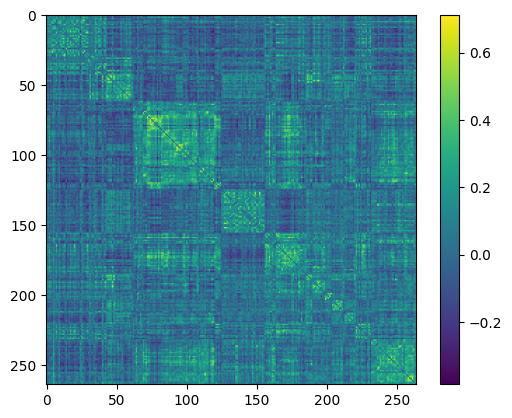

In [50]:
import matplotlib.pyplot as plt

xx = ae(x).detach().cpu().numpy()

plt.imshow(remap(vec2mat(xx[1])))
plt.colorbar()
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score

def rmse(yhat, yt):
    return np.mean((yhat-yt)**2)**0.5

xtr, xt, ytr, yt = train_test_split(fc-xx, race, stratify=race, train_size=0.8)

reg = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr) #Ridge(alpha=1).fit(xtr, ytr)
p = reg.predict_proba(xt)
print(roc_auc_score(yt, p[:,1]))

0.3364542434309876
